# Exploring Hypotheses on Synthetic Functions  

The purpose of this notebook is to find out more about the effect of the sampling bias and measures against it. 

In particular, we will explore the following hypotheses: 

* Why should we compute the PDP on uniformly distributed test data? 
* What is the effect of the sampling bias on the PDP? 
* How can we capture this effect an tell the user? 
* How can we reduce the sampling bias? 



In [1]:
# test function
library("smoof")
library("ParamHelpers")

# data handling
library("data.table")
library("BBmisc")

# visualization
library("plot3D")
library("ggplot2")
library("GGally")
library("gridExtra")
library("rpart.plot")
library("rattle")
library("RColorBrewer")
library("DiceKriging")

# mlrMBO
library("mlrMBO")
library("mlr")

# iml methods
library("iml")

# splitting
# withr::with_envvar(c(R_REMOTES_NO_ERRORS_FROM_WARNINGS="true"),remotes::install_github('giuseppec/customtrees'))
library("customtrees")

theme_set(theme_bw())

source("../R/benchmarks/synthetic/mbo_helpers.R")
source("../R/pdp_helpers.R")



Loading required package: ParamHelpers

Loading required package: checkmate


Attaching package: ‘BBmisc’


The following object is masked from ‘package:base’:

    isFALSE


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: rpart

Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.


Attaching package: ‘DiceKriging’


The following object is masked from ‘package:checkmate’:

    checkNames


Loading required package: mlr

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).



In [2]:
options(repr.plot.width=10, repr.plot.height=10)


## Scenario - Optimizing a Synthetic Test Function via mlrMBO

### Preparation: Objective Function

We optimize the 3D StyblinkskiTang function. 

In [3]:
obj1 = makeSingleObjectiveFunction(name = "StyblinkskiTang3D", fn = function(x) {
        1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 3, lower = - 5, upper = 5))
)

obj = obj1

In [4]:
# obj2 = makeSingleObjectiveFunction(name = "Rastrigin", fn = function(x) {
#         20 + sum(x^2 - 10 * cos(2 * pi * x))
#     }, 
#     par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 3))# 
# )

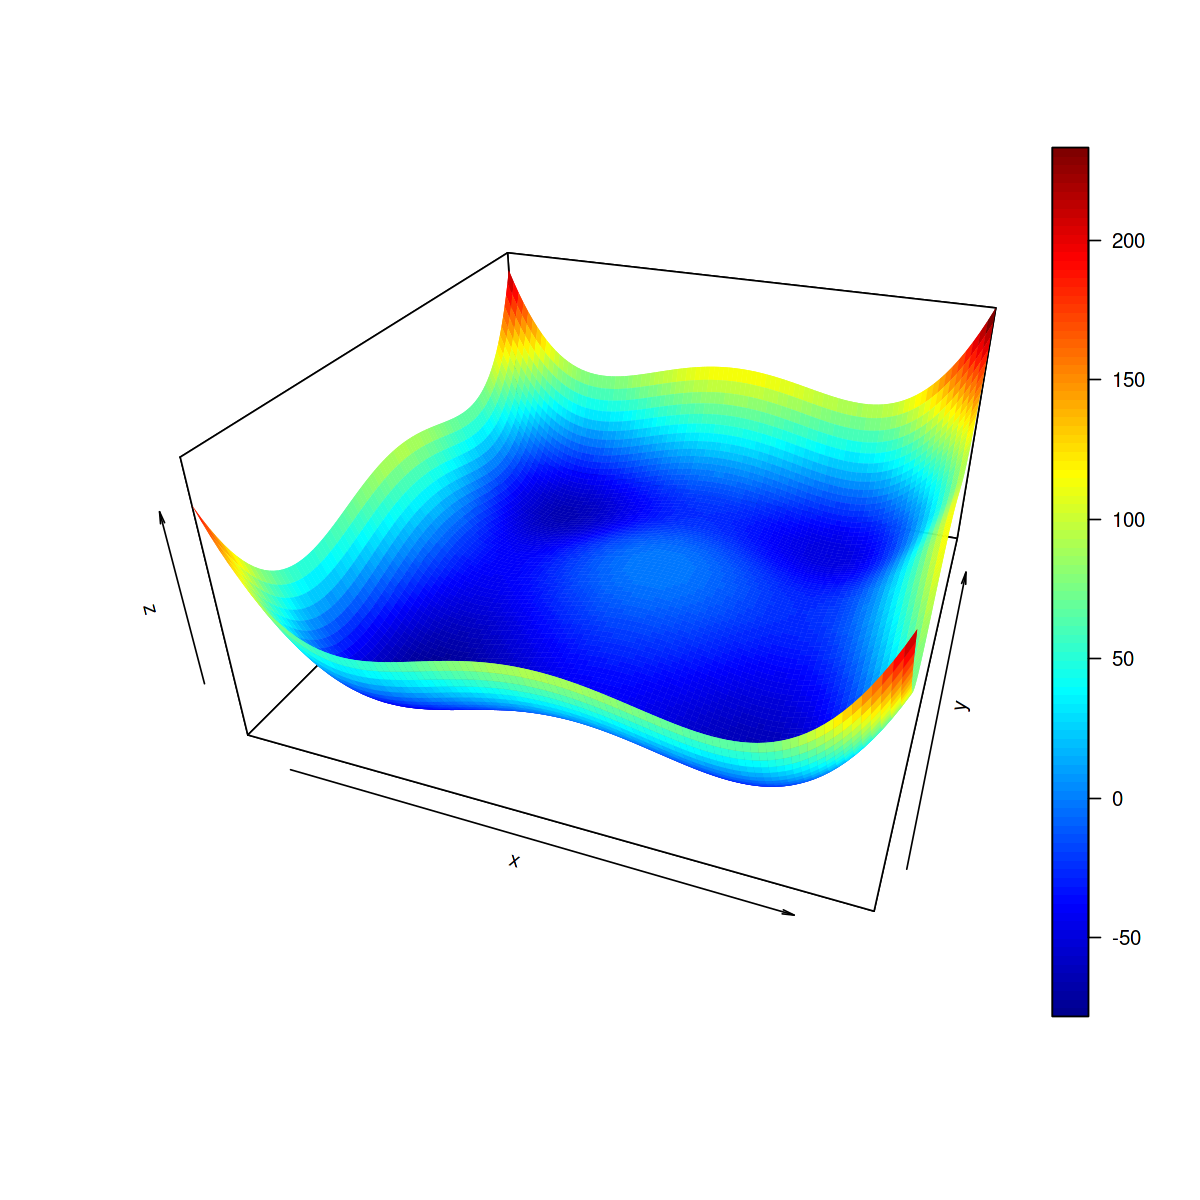

In [5]:
ps = getParamSet(obj1)

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x2 <- x1
y = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj1))
          
persp3D(x1, x2, y, theta = 20, phi = 30, expand = 0.5, border = NA)

In [6]:
# ps = getParamSet(obj2)

# x11 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
# x22 <- x11
# y2 = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj2))
          
# persp3D(x11, x22, y2, theta = 20, phi = 30, expand = 0.5, border = NA)

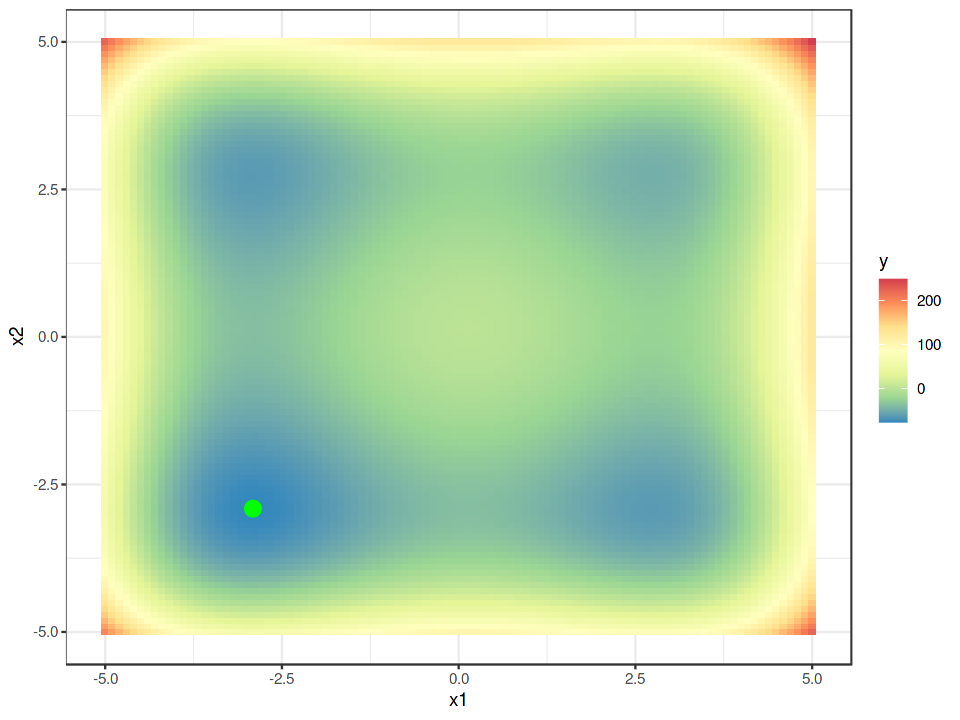

In [7]:
options(repr.plot.width=8, repr.plot.height=6)

gg <- expand.grid(x1 = x1, x2 = x2)
gg$y = apply(gg, 1, obj1)

# gg2 <- expand.grid(x1 = x11, x2 = x22)
# gg2$y = apply(gg2, 1, obj2)


p_obj_1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = y))
p_obj_1 = p_obj_1 + scale_fill_distiller(palette = "Spectral")
p_obj_1 = p_obj_1 + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)

# p_obj_2 = ggplot() + geom_tile(data = gg2, aes(x = x1, y = x2, fill = y))
# p_obj_2 = p_obj_2 + scale_fill_distiller(palette = "Spectral")
# p_obj_2 = p_obj_2 + geom_point(data = data.frame(x = 0, y = 0), aes(x = x, y = y), colour = "green", size = 4)

p_obj_1

### Preparation: Creating MBO Runs

Next, we create `mlrMBO` runs as well as a model fitted on the randomLHS data. 

In [8]:
createMBOrun(fun = obj, max.evals = 70, lambda = 0.1, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds", seed = 1234)

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generat

ERROR: Error in gzfile(file, mode): cannot open the connection


In [ ]:
createMBOrun(fun = obj, max.evals = 70, lambda = 1, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds", seed = 1234)

In [ ]:
createMBOrun(fun = obj, max.evals = 70, lambda = 2, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_2.rds", seed = 1234)

In [ ]:
createMBOrun(fun = obj, max.evals = 70, lambda = 10, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds", seed = 1234)

In [ ]:
createMBOrun(fun = obj, max.evals = 70, type = "LHS", store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_lhs.rds", init_size = 50, seed = 1234)

In [11]:
runs = list(MBO_0.1 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds"), 
            MBO_1 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds"),
            # MBO_2 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_2.rds"),
            MBO_10 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds")# , 
            # LHS = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_lhs.rds")
           )

In [12]:
types = get_types_of_runs(runs)
models = extract_models(runs)
names(models) = types
opdf = concatenate_runs(runs)

opdf$type = factor(opdf$type, levels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1"), labels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1")) 

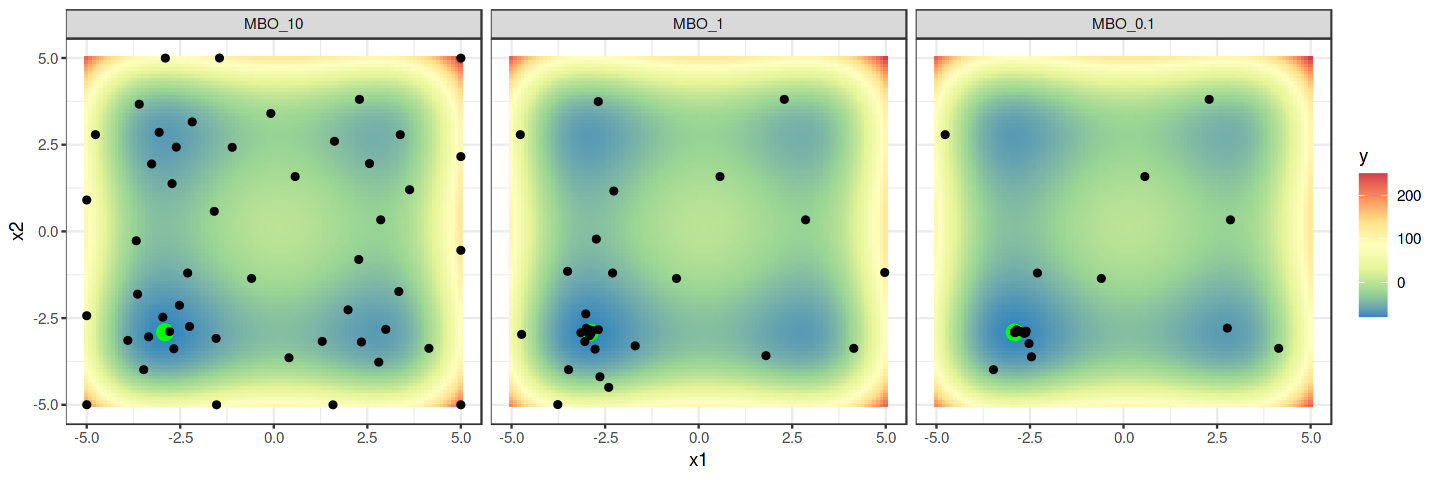

In [13]:
options(repr.plot.width=12, repr.plot.height=4)

p1 = p_obj_1 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p1 = p1 + facet_wrap(. ~ type) 
p1

### Preparation: Investigating the Fit

In [23]:
gg = generateGridDesign(par.set = ps, resolution = 50)
gg$y = apply(gg, 1, obj1)

In [24]:
preds = lapply(names(models), function(idx) {
    pp = predict_on_grid(models[[idx]], gg)
    pp$type = idx
    pp
})
preds = do.call(rbind, preds)

preds$type = factor(preds$type, levels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1"), labels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1")) 

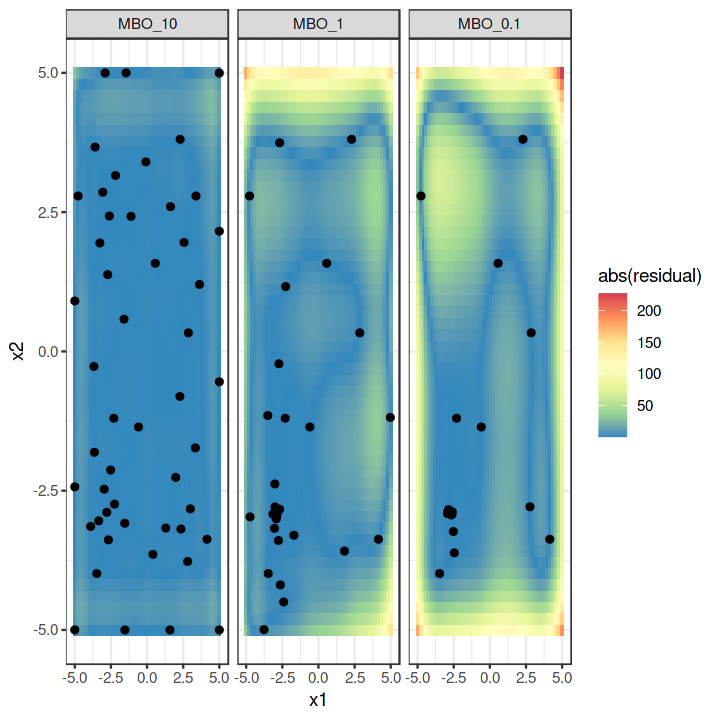

In [25]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = abs(residual)))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

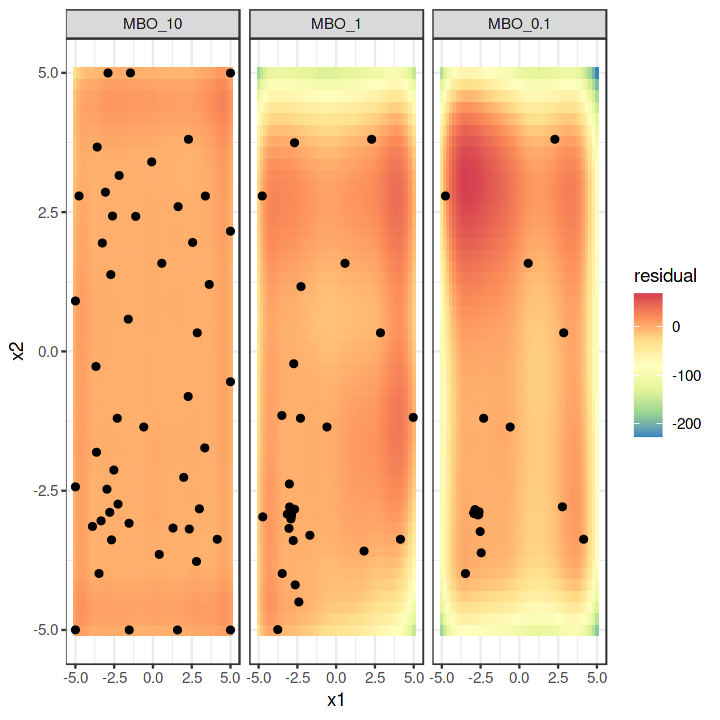

In [26]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = residual))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

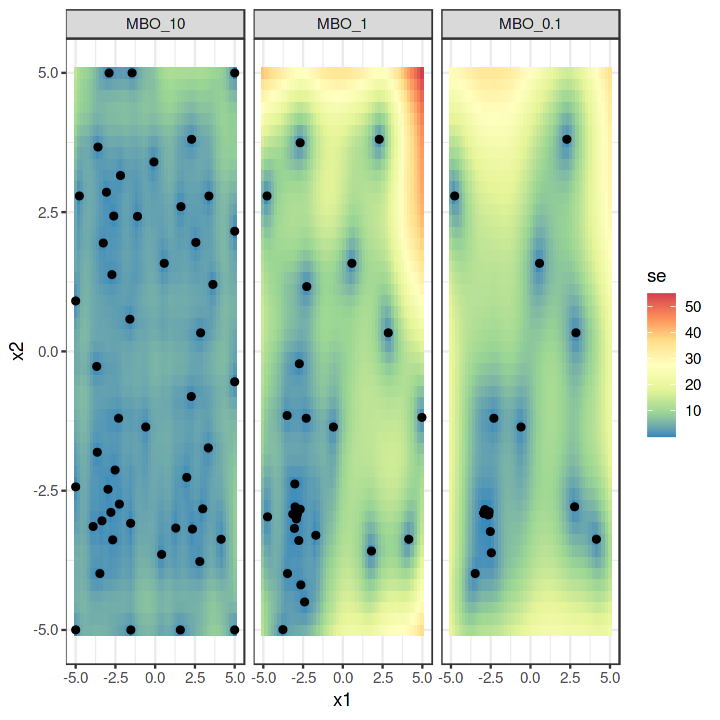

In [27]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

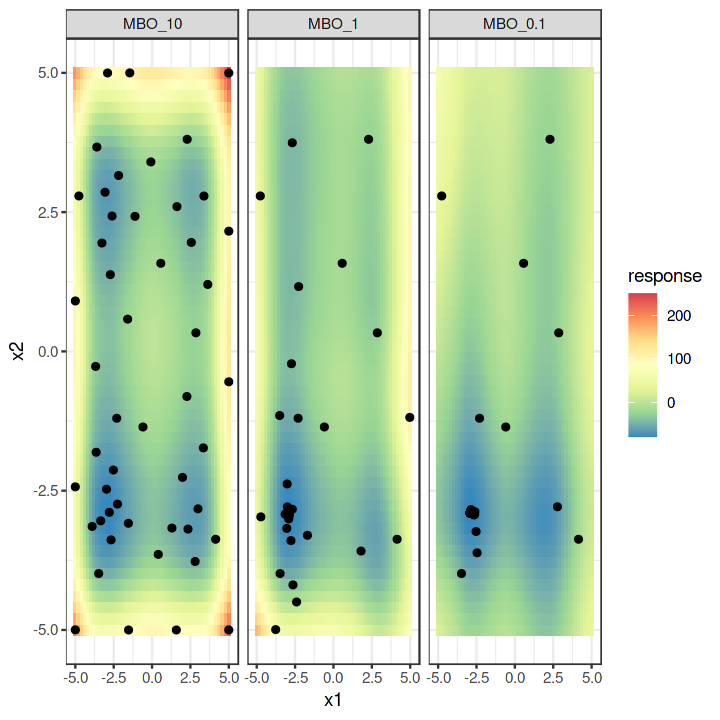

In [28]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = response))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

# High error means over-estimation 

### Question 1: Computing the PDP on Training or Test Data? 

A partial dependence plot tries to approximate the following: 

\begin{align*}
\hat f(x_S) & = \mathbb{E}_{x_C}[\hat f(x_S, x_C)] = \int \hat f(x_S, x_C) d\mathbb{P}(x_C)
\end{align*}

The mathematical correct variants of the ground-truth for $\hat f = f$ look like this: 

* Data situation 1: Ground-truth objective and $\mathbb{P}$ is the uniform distribution (ideal world)

\begin{align*}
\hat f_1(x_1) & = (-25 + 15 x_1 - 48 x_1^2 + 3 x_1^4) / 6 \\
\hat f_2(x_1) & = 8 x_1^2 - 80 cos(2 \pi x_1) + 632/3
\end{align*}

* Data situation 2: Ground-truth objective and $\mathbb{P}$ is the distribution from a perfect optimizer which immediately detects the optimum at $x^* = (-2.903.., - 2.903)$.

\begin{align*}
\hat f(x_1) & = 0.5 (x_1^4 - 16 x_1^2 + 5 x_1 - 78.3323) \\
\hat f_2(x_1) &= 20 + x_1^2 - 10 \cos(2 \pi x_1) - 10
\end{align*}

If we fit a PDP on the MBO data we usually approximate something in between. 

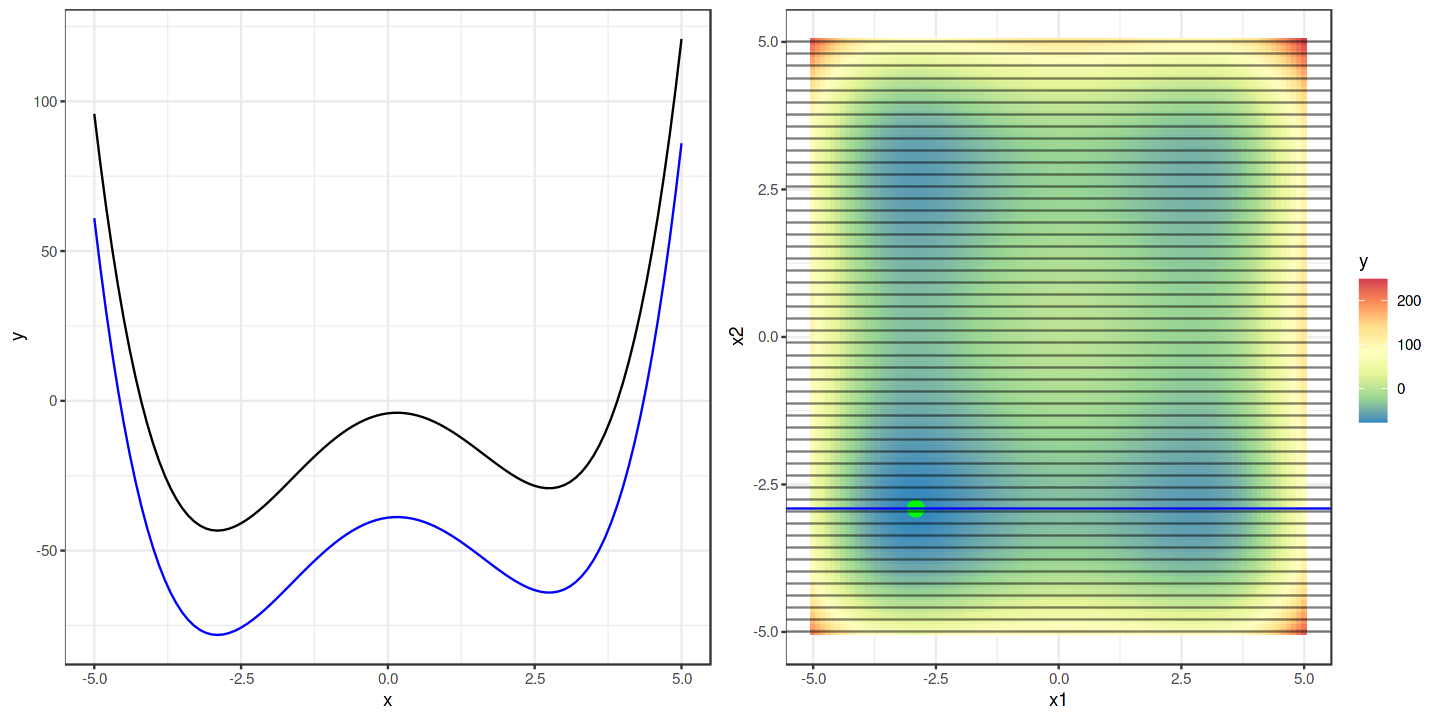

In [29]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 6 * (3 * x^4 - 48 * x^2 + 15 * x - 25))
lines = seq(-5, 5, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 2 * (x^4 - 16 * x^2 + 5 * x - 78), colour = "blue")
p2 = p_obj_1 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

In case 1 we are interested in the average feature effect of $x_1$ on $y$.

In case 2 we are interested in the feature effect of $x_1$ on $y$ given $x_2 = x_2^*$.

Usually, what we approximate is something in between but we converge to scenario 2. 

### Question 2: What is the Sampling Bias? 

We compare the partial dependence plots against the ground-truth PDP. 

In [30]:
data = generateRandomDesign(100, getParamSet(obj))

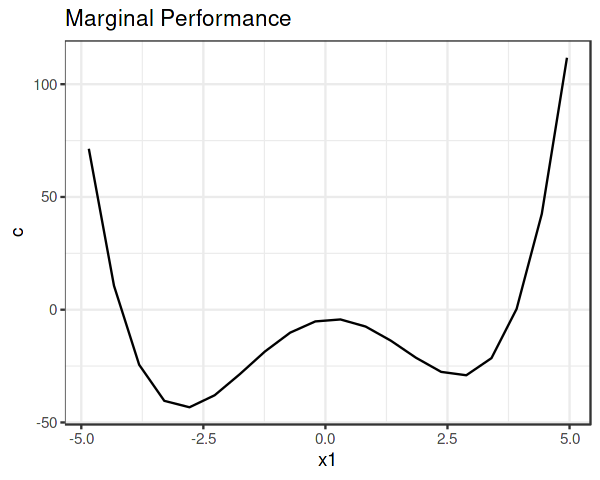

In [31]:
options(repr.plot.width=5, repr.plot.height=4)

marginal_gt = marginal_effect(obj, "x1", data)

(p = ggplot(data = marginal_gt, aes(x = x1, y = mean)) + geom_line() + ggtitle("Marginal Performance") + ylab(c("c")))

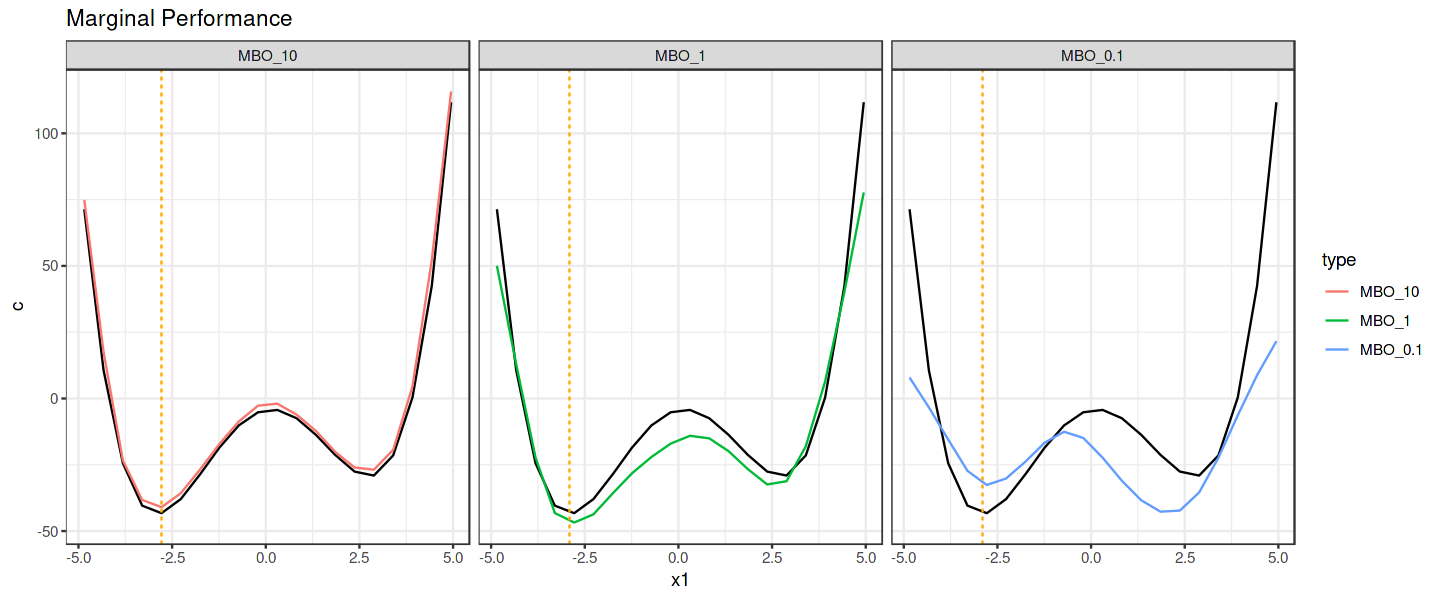

In [32]:
options(repr.plot.width=12, repr.plot.height=5)

marginal_pd = lapply(names(models), function(m) {
    pp = predicted_marginal_effect(models[[m]], "x1", data)
    # pp = predicted_marginal_effect(models[[m]], "x1", as.data.frame(runs[[m]]$opt.path))
    pp$type = m
    pp
})

mins = opdf[, .SD[which.min(y)], by = type]

marginal_pd = do.call(rbind, marginal_pd)
marginal_pd$type = factor(marginal_pd$type, levels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1"), labels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1")) 
marginal_pd = as.data.table(marginal_pd)

pl = p + geom_line(data = marginal_pd, aes(x = x1, y = mean, colour = type))                        
pl = pl + geom_vline(data = mins, aes(xintercept = x1), colour = "orange", lty = 2)
pl + facet_grid(. ~ type)  

In [33]:
# Capturing the bias in numbers 

# Compute the absolute deviation

res = lapply(names(models), function(m) {
    mm = marginal_pd[type == m, ]
    mm = merge(mm, marginal_gt, by = "x1")
    mm$dev_abs = mm$mean.x - mm$mean.y
    c(mean(abs(mm$dev_abs)), sd(mm$dev_abs)) 
})

res = do.call(rbind, res)
rownames(res) = names(models)
colnames(res) = c("Mean Abs. Difference", "SD Abs. Difference")
res

,Mean Abs. Difference,SD Abs. Difference
MBO_0.1,18.832014,25.433504
MBO_1,8.002733,8.973990
MBO_10,2.767751,2.128476


### Question 3: How Can We Capture this Effect? 

We use the uncertainty to capture this effect. 

#### Variant 1 (Partial Dependence Plot over the Posterior Variance)

$$
    \hat s(\lambda_S) = \sqrt{\frac{1}{n^2} \sum_{i = 1}^n \hat s^2(\lambda^{(i)})} = \frac{1}{n} \sqrt{ \sum_{i = 1}^n \hat s^2(\lambda^{(i)})}
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 2 (Partial Dependence Plot over Standard Deviation)

At least in my opinion, this is not mathematically valid...?

$$
    \hat s(\lambda_S) = \frac{1}{n}  \sum_{i = 1}^n \hat s(\lambda^{(i)})
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 3 (Partial Dependence Taking into Account GP Covariance)

$$
    \hat s(\lambda_S) = \frac{1}{n} \sqrt{\sum_{i,j} K^{(post)}_{i,j}}
$$

In [34]:
results = list()

for (method in c("pdp_var_gp", "thompson", "pdp_sd", "pdp_var")) {
    res = lapply(names(models), function(m) {
        pp = marginal_effect_sd_over_mean(models[[m]], "x1", data, method = method)
        # pp = marginal_effect_sd_over_mean(models[[m]], "x1", as.data.frame(runs[[m]]$opt.path), method = method)
        pp$type = m
        pp
    })
    res = do.call(rbind, res)
    res$method = method
    results[[method]] = res
}

In [35]:
results = do.call(rbind, results)

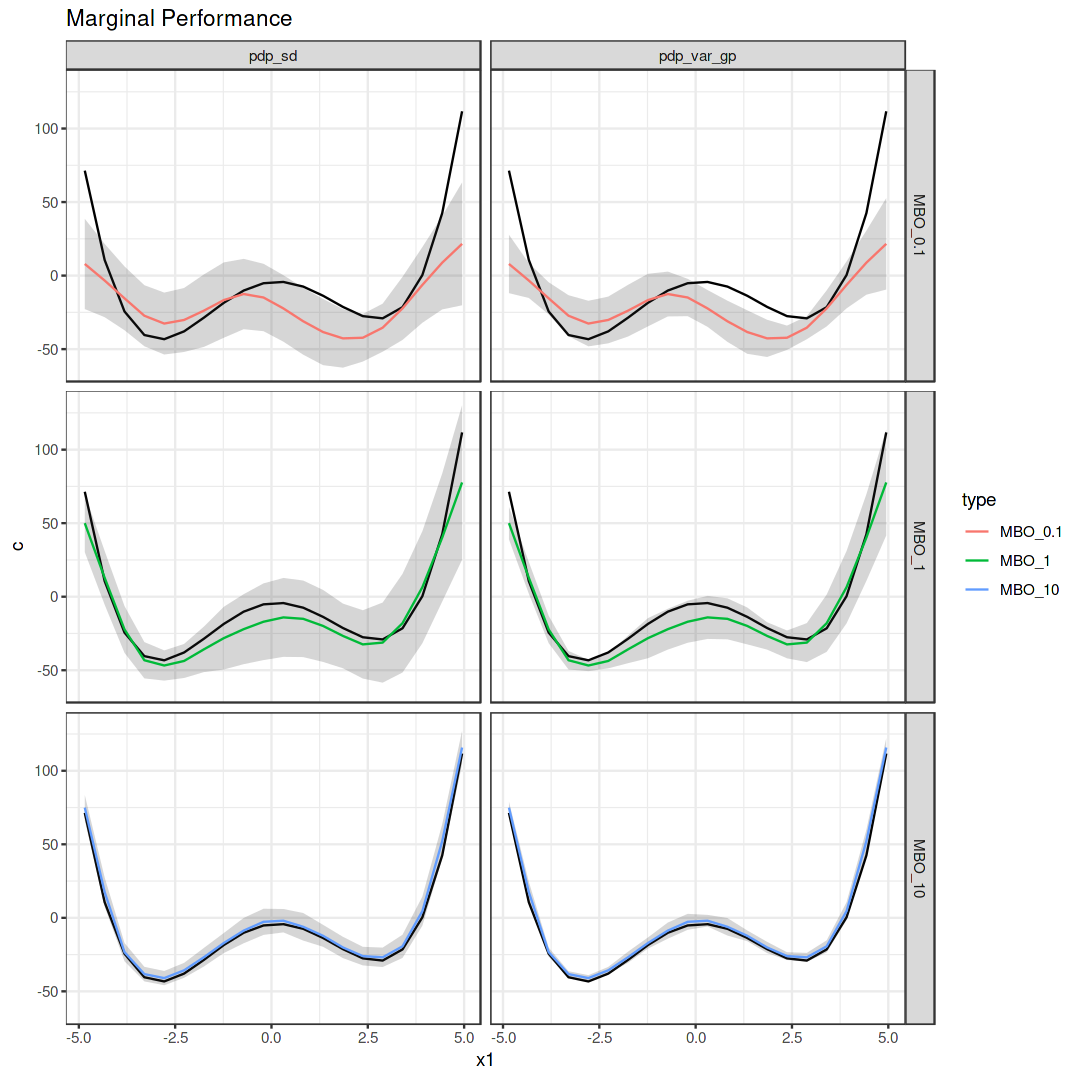

In [36]:
options(repr.plot.width=9, repr.plot.height=9)

pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp", "pdp_sd"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var_gp", "pdp_sd"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
pl2 = pl
pl

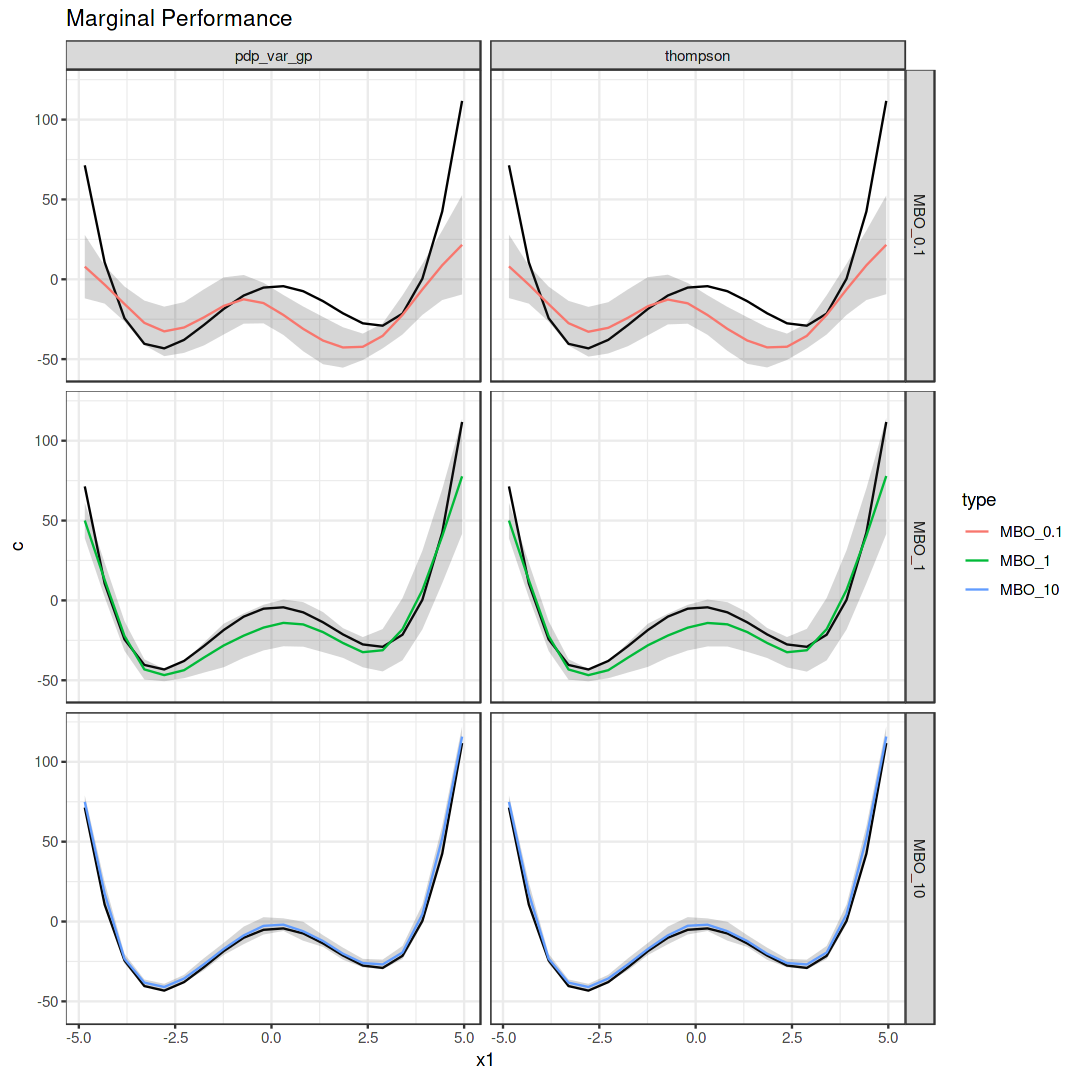

In [37]:
options(repr.plot.width=9, repr.plot.height=9)

pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp", "thompson"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var_gp", "thompson"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
pl

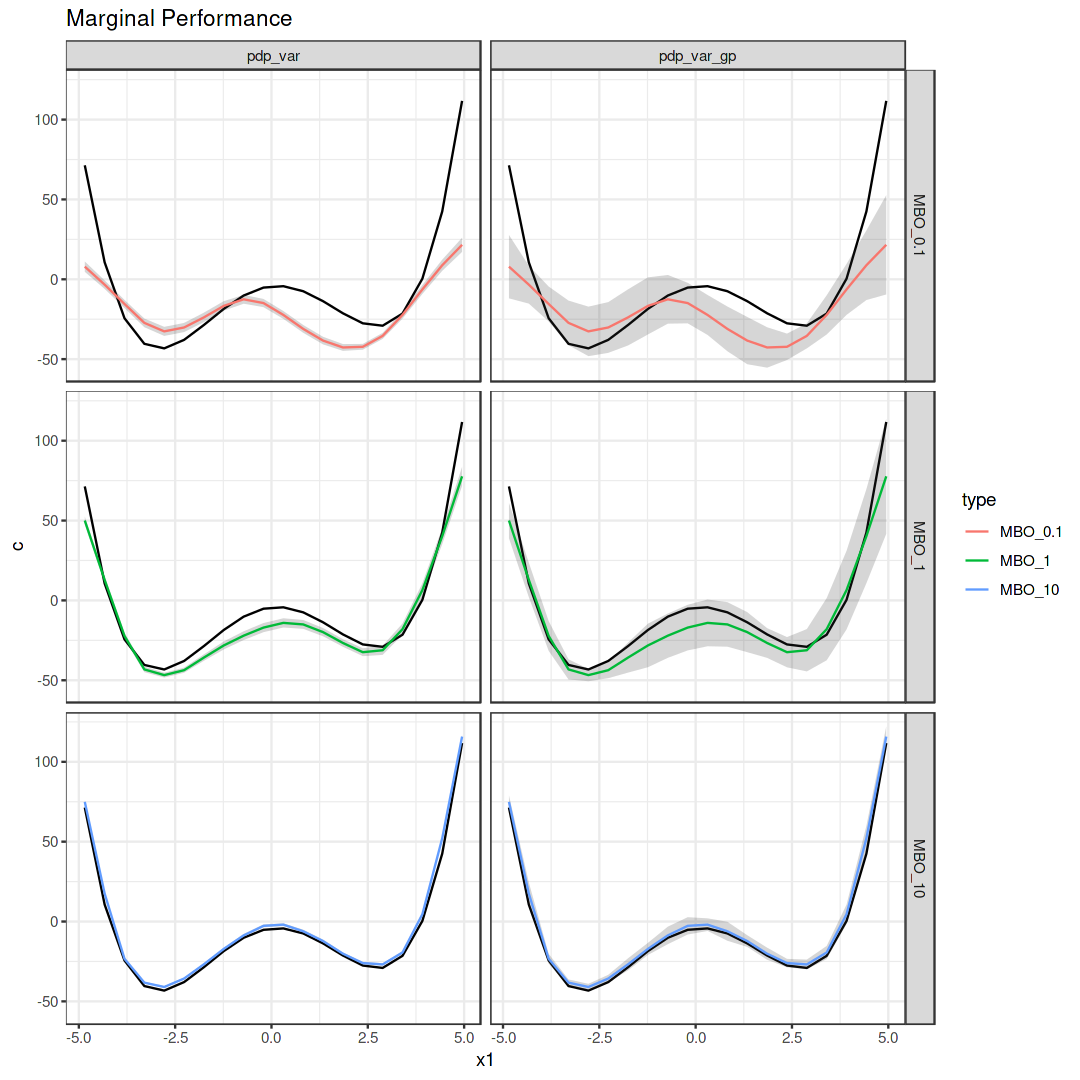

In [38]:
options(repr.plot.width=9, repr.plot.height=9)

pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp", "pdp_var"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var_gp", "pdp_var"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
pl

In [39]:
# Alternative Approach 
results2 = list()

for (method in c("pdp_cond", "pdp_cond_thomps")) {
    res = lapply(names(models), function(m) {
        pp = conditional_mean_sd(models[[m]], "x1", data, method = method)
        pp$type = m
        pp
    })
    res = do.call(rbind, res)
    res$method = method
    results2[[method]] = res
}

In [40]:
results2 = do.call(rbind, results2)

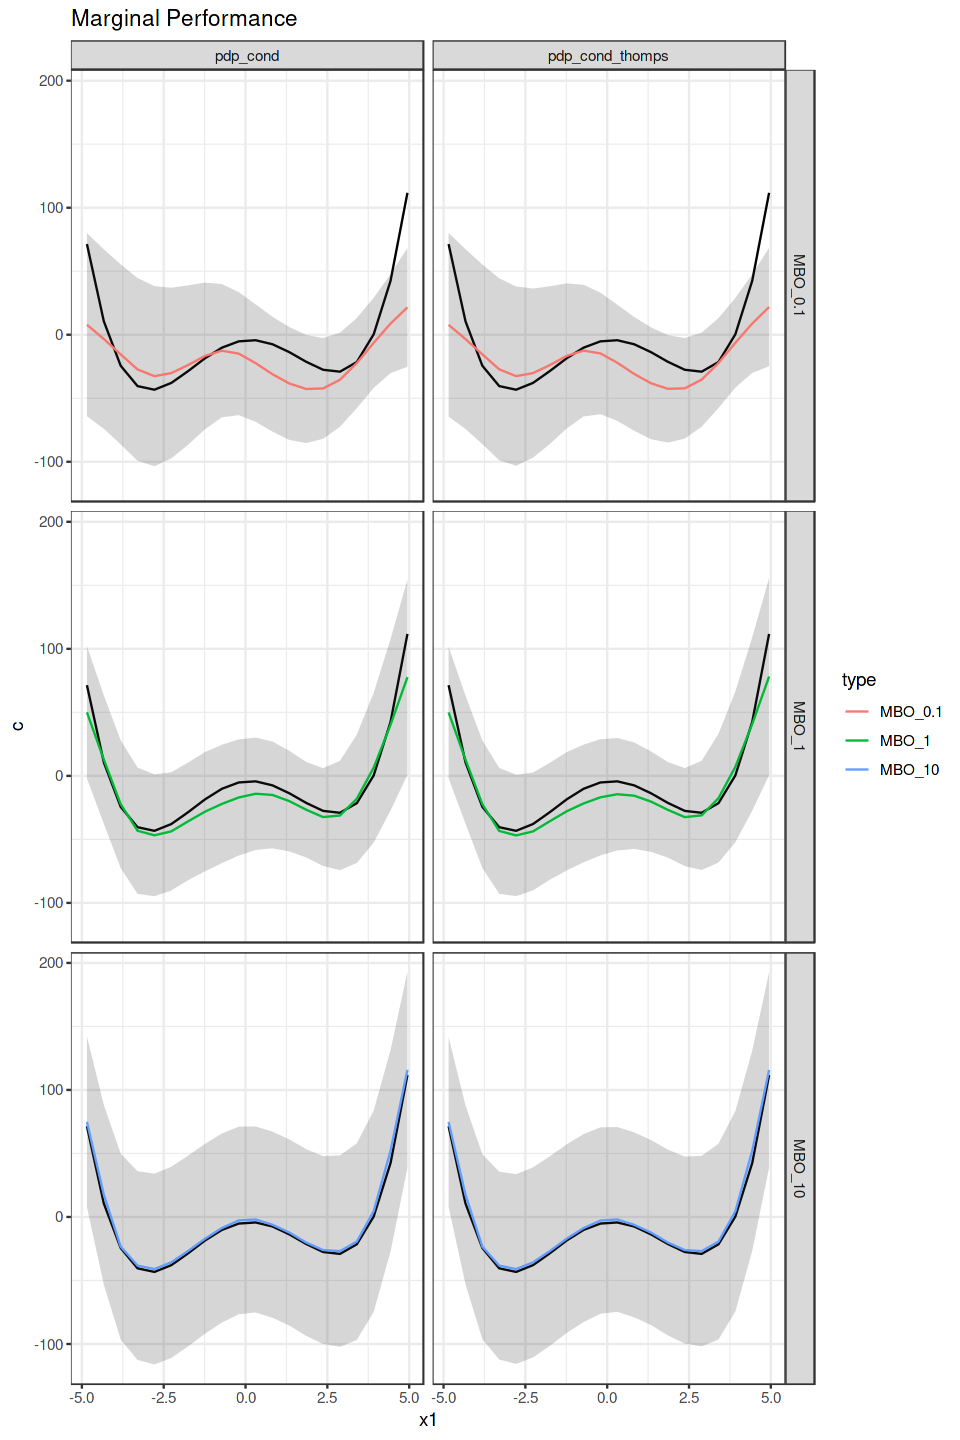

In [41]:
options(repr.plot.width=8, repr.plot.height=12)

pl = p + geom_ribbon(data = results2, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
pl = pl + geom_line(data = results2, aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
pl

## Further Visualization for the Paper

In [31]:
plotPDPICE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp+ice")
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }    
    return(p)
}

In [32]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("MBO-model on test data") 
p2 = plotPDP(obj1, "LHS", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("LHS-model on test data") 
grid.arrange(p1, p2, ncol = 2)

ERROR: Error in plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE): could not find function "plotPDP"


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

preds = setDT(preds)

example_ice_curves = data.frame(y = c(2.5, -1), type = c("ice_curve_1", "ice_curve_2"))

# Explanation
p2 = ggplot() + geom_tile(data = preds[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 = p2 + geom_hline(data = example_ice_curves, aes(yintercept = y, colour = type))

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 6)

x1 = seq(-5, 5, by = 0.01)
df_ice = data.frame(x1 = x1, x2 = example_ice_curves$y[1], type = "ice_curve_1")
df_ice = rbind(df_ice, data.frame(x1 = x1, x2 = example_ice_curves$y[2], type = "ice_curve_2"))
pred = predict(models[["lambda1"]], newdata = df_ice[, c("x1", "x2")])
df_ice$response = pred$data$response
df_ice$se = pred$data$se
df_ice$gt = apply(df_ice[, c("x1", "x2")], 1, obj1)

p1 = ggplot() 
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

In [ ]:
p1 = ggplot()
p1 = p1 + geom_ribbon(data = df_ice, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), fill = "grey70", alpha = 0.5)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

### Question 4: What Can We Do Against It? 

In [95]:
model_for_interpretation = "MBO_0.1"
model = models[[model_for_interpretation]]

In [96]:
# We now fit a tree to the se of the model to extract regions with low uncertainty
train_data_tree = generateDesign(n = 1000, par.set = ps, fun = lhs::randomLHS)
pred = predict(model, newdata = train_data_tree)

train_data_tree$response = pred$data$response
train_data_tree$se = pred$data$se

In [97]:
lrn_tree = makeLearner("regr.rpart", par.vals = list(maxdepth = 4, minbucket = 50, cp = 0.01))
task = makeRegrTask(data = train_data_tree[, c("x2", "se")], target = "se")
mod = train(lrn_tree, task)

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


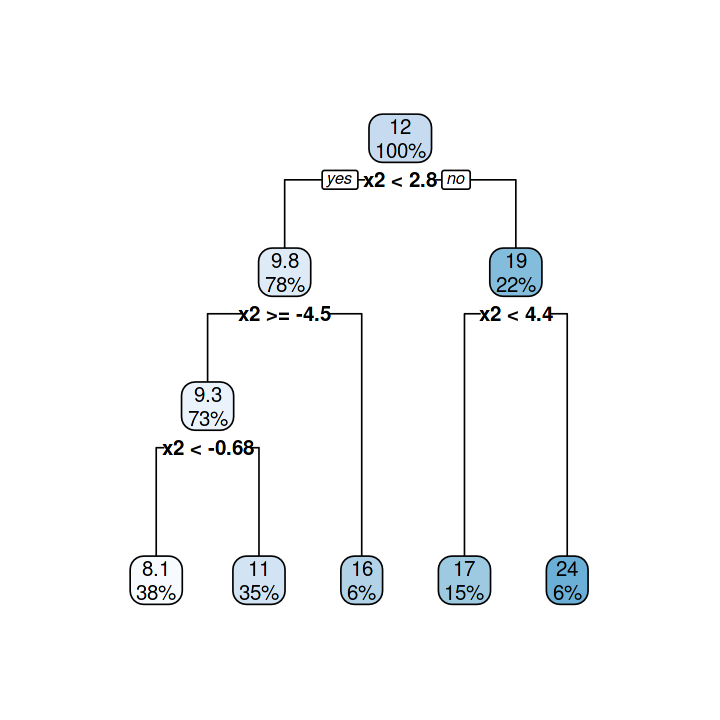

In [98]:
rpart.plot(mod$learner.model)

In [99]:
pred_rpart = predict(mod, task)

In [100]:
splits = as.data.frame(mod$learner.model$splits)$index
splits

[1]  2.8293617 -4.4530752 -0.6768086  4.3701008

In [101]:
preds = as.data.table(preds)

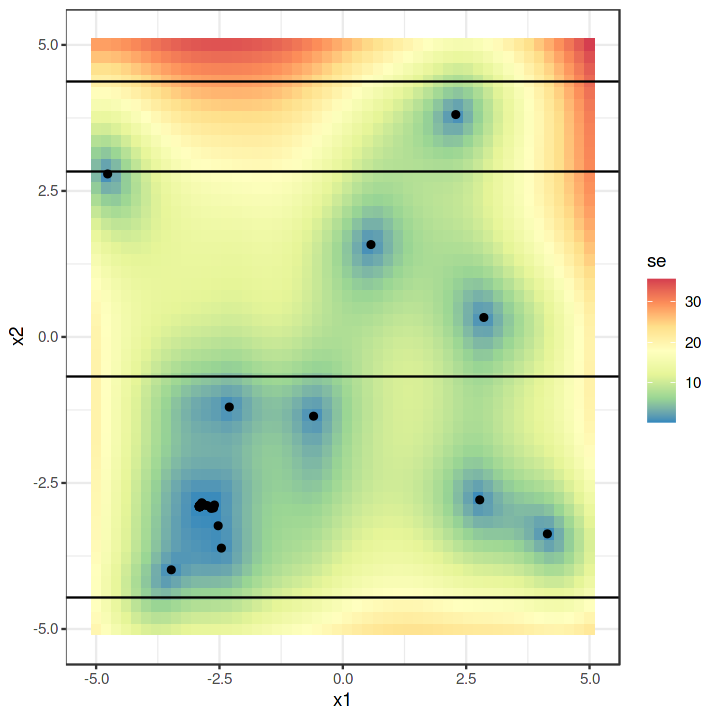

In [102]:
options(repr.plot.width = 6, repr.plot.height = 6)

p1 = ggplot(data = preds[type == model_for_interpretation, ], aes(x = x1, y = x2, fill = se)) + geom_tile() + geom_point(data = opdf[type == "MBO_0.1", ], aes(x = x1, y = x2)) 
p1 = p1 + geom_hline(yintercept = splits) + scale_fill_distiller(palette = "Spectral")
p1

In [103]:
rules = rpart.rules(mod$learner.model)
rules

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.rules with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


,se,,,,,,
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
8,8.1,when,x2,is,-4.45,to,-0.68
9,10.6,when,x2,is,-0.68,to,2.83
5,15.8,when,x2,<,-4.45,,
6,16.8,when,x2,is,2.83,to,4.37
7,24.1,when,x2,>=,,,4.37


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


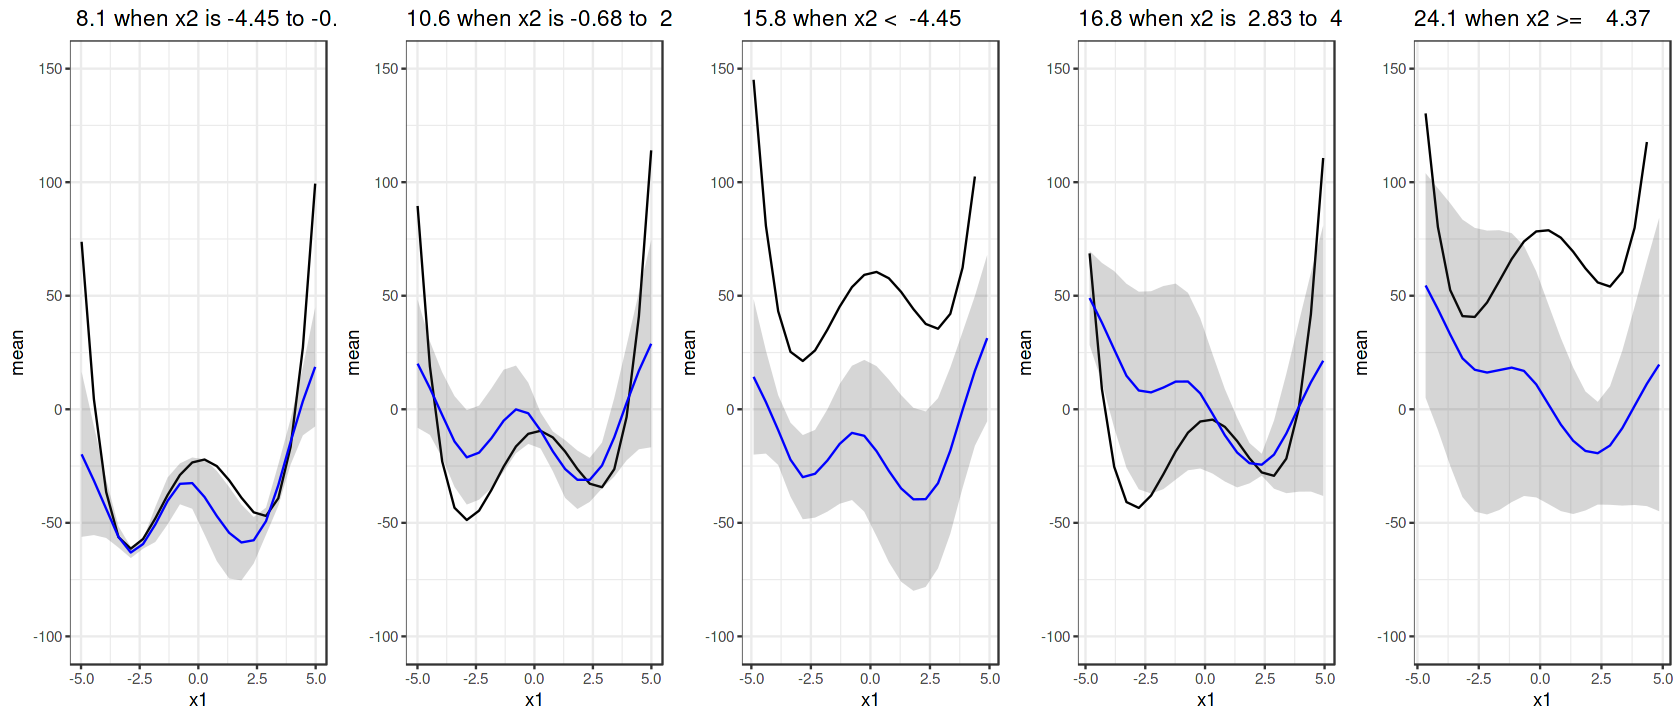

In [254]:
options(repr.plot.width = 14, repr.plot.height = 6)

pdd = predict(mod$learner.model)


sub_pdps = lapply(rownames(rules), function(node) {
    # First, get the value of that node
    yval = mod$learner.model$frame[node, ]$yval

    # Filter for those points where we have this predictions
    idx = which(pdd == yval)
    train_data_sub = train_data_tree[idx, ]

    gt_sub = marginal_effect(obj, "x1", train_data_sub)
    pd_sub = marginal_effect_sd_over_mean(model = model, feature = "x1", data = train_data_sub, method = "pdp_var_gp")

    p = ggplot(data = gt_sub, aes(x = x1, y = mean)) + geom_line()
    p = p + geom_ribbon(data = pd_sub, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
    p = p + geom_line(data = pd_sub, aes(x = x1, y = mean), colour = "blue") + ggtitle(do.call(paste, rules[node, ]))
    p + ylim(c(-100, 150))
})

do.call(grid.arrange, c(sub_pdps, nrow = 1))

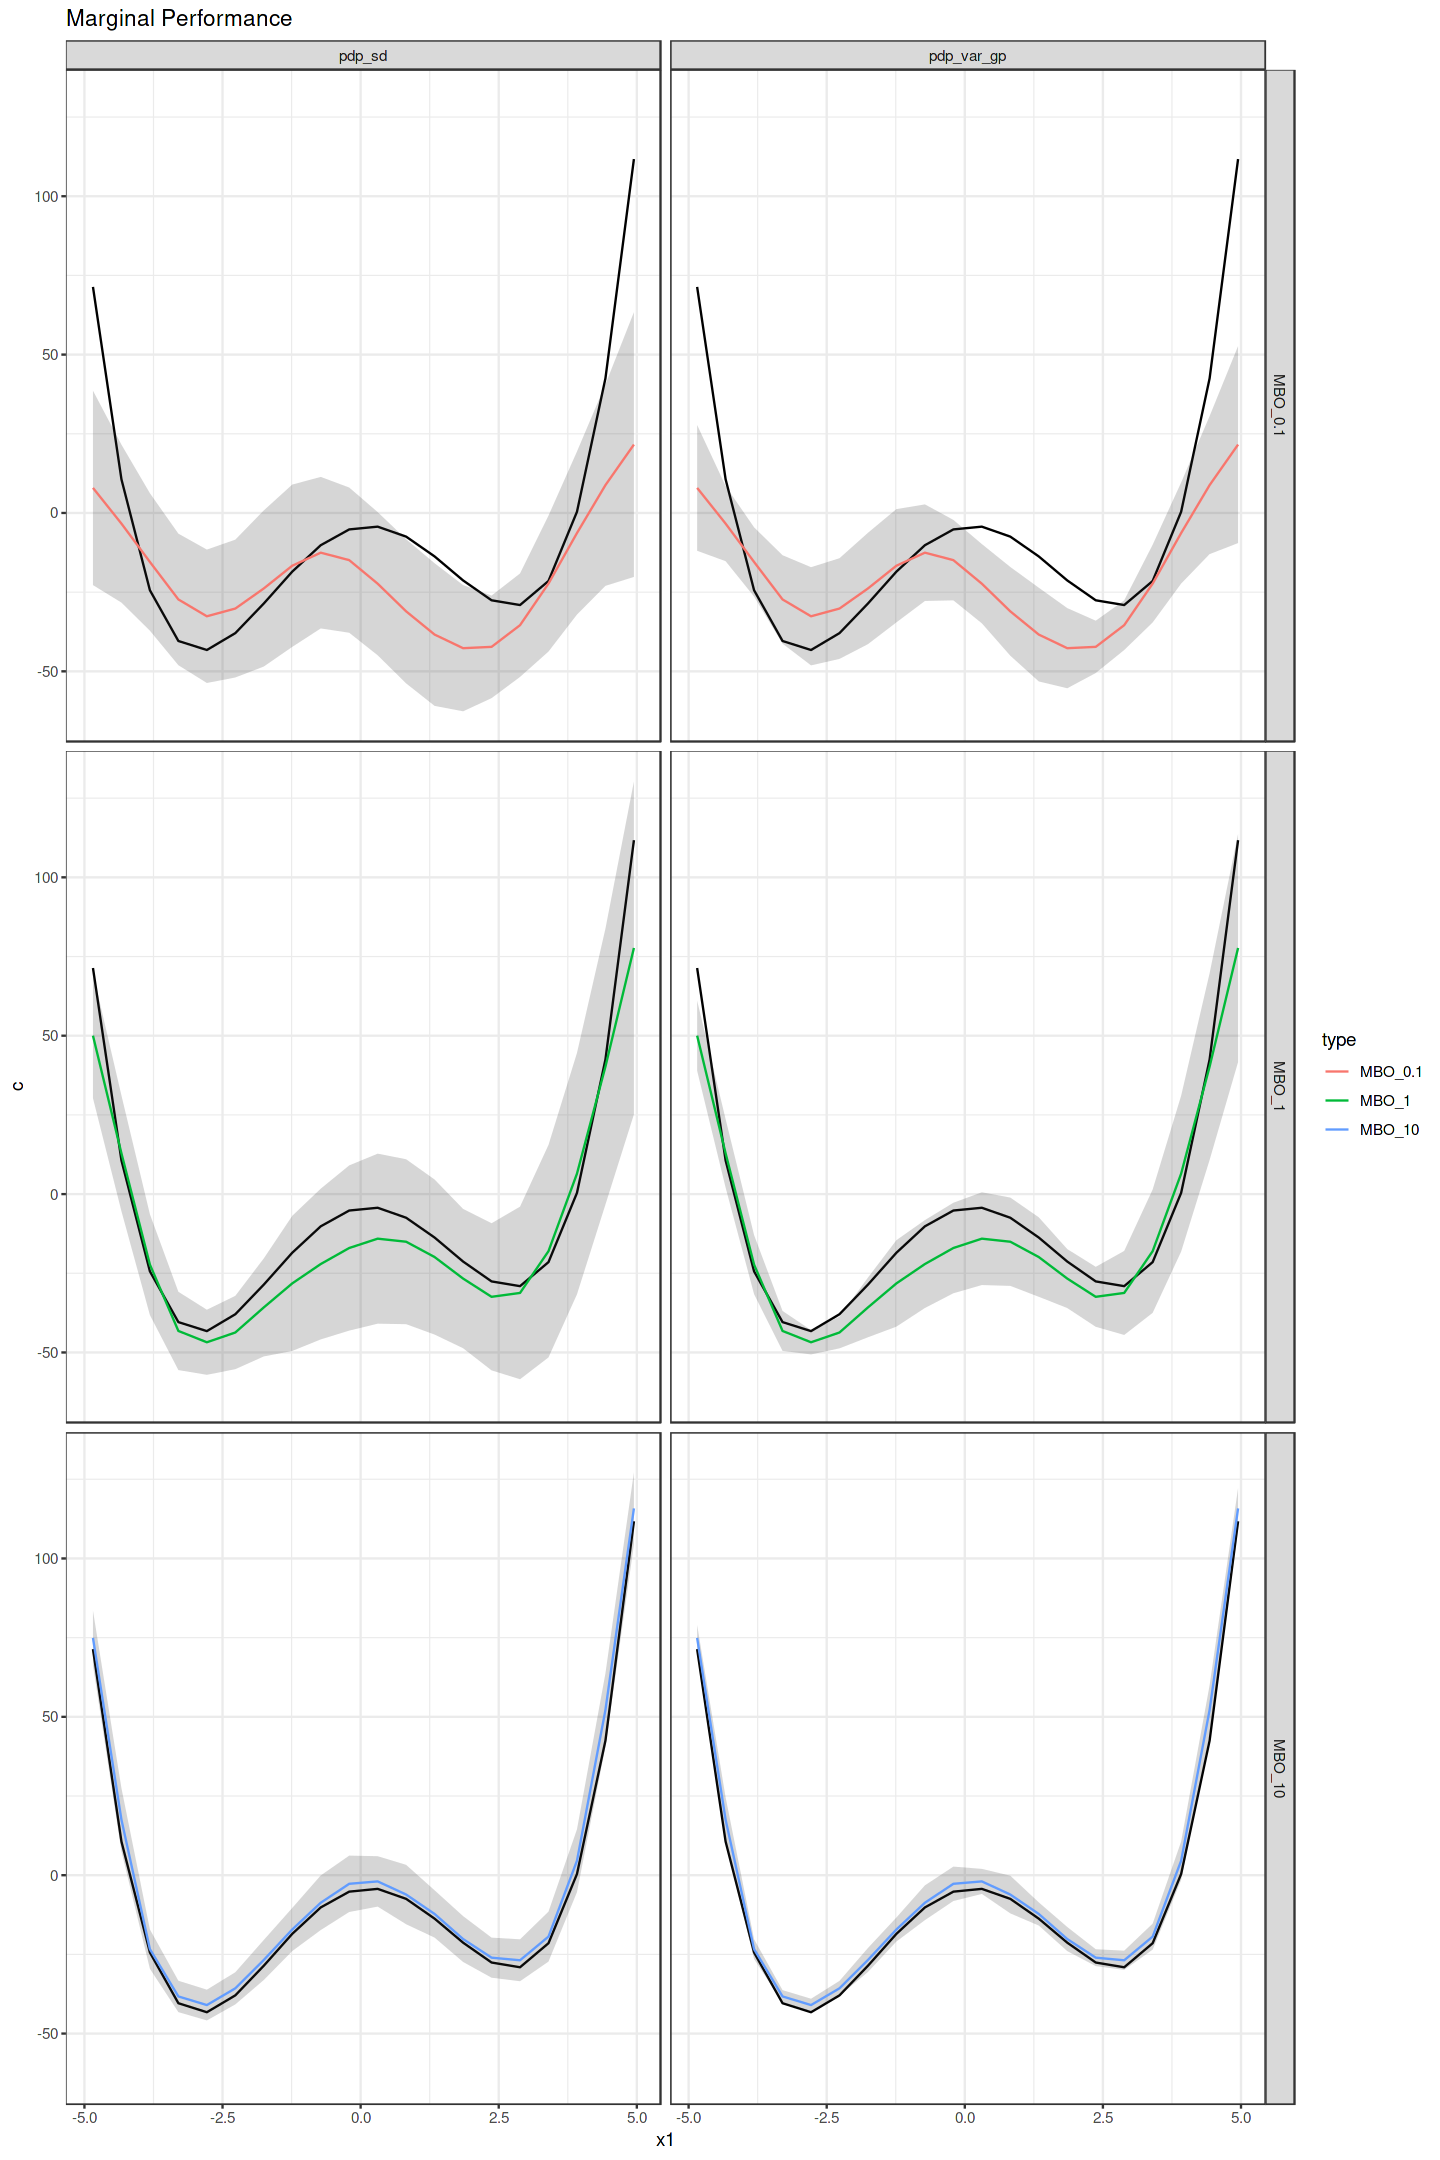

In [255]:
options(repr.plot.width = 12, repr.plot.height = 18)

pl2

In [403]:
df = generateDesign(par.set = ps, n = 100, fun = lhs::randomLHS)

mymodel = makeS3Obj("mymodel", fun = function() return(model))

predict.mymodel = function(object, newdata) {
  pred = predict(object$fun(), newdata = newdata)
  getPredictionSE(pred) 
}

predictor = Predictor$new(mymodel, data = df, predict.function = predict.mymodel)

effect = FeatureEffect$new(predictor, method = "ice", grid.size = 20, feature = "x1")

eff = data.table(effect$results)
                    
df$.id = seq_len(nrow(df))

In [419]:
compute_tree = function(effect, df, objective, n.splits) {
    
    ice_feat = effect$feature.name
    all_feats = effect$predictor$data$feature.names
    split_feats = setdiff(all_feats, ice_feat)
    
    print(split_feats)
    
    effects = data.table(effect$results)
    effects = merge(effects, df[, c(".id", split_feats)], by = ".id")
  
    print("test")
    
    Y = tidyr::spread(eff, ice_feat, .value)
    Y = as.data.frame(Y)
    Y = Y[, setdiff(colnames(Y), c(".type", ".id"))]
    
    X = df[, split_feats, drop = FALSE]
    split = split_parent_node(Y = Y, X = X, objective = SS_L1, optimizer = find_best_binary_split)
    node_idx = generate_node_index(Y = Y, X = X, result = split)
    
    results = list()
    
    results[[1]] = list(list(splitfeat = split$feature, splitpoint = split$split.points[[1]], idx = node_idx))
    
    for (depth in seq_len(n.splits)) {
        
        results[[depth + 1]] = list()
        
        for (node in results[[depth]]) {
            
            # Level d, node n
            idx = node$idx 
            splitpoint = node$splitpoint
            splitfeat = node$splitfeat
            
            # Split Left child
            idx_sub = which(effects[, splitfeat] <= splitpoint)
            Y = tidyr::spread(effects[idx_sub, c(ice_feat, ".value", ".type", ".id")], ice_feat, .value)
            Y = as.data.frame(Y)
            Y = Y[, setdiff(colnames(Y), c(".type", ".id"))]
            
            idx_full = seq_len(nrow(df))
            idx_full[idx$index[[1]], ]
            
            X = df[idx$index[[1]], ]
            X = df[, c(split_feats), drop = FALSE]
            
            split = split_parent_node(Y = Y, X = X, objective = objective, optimizer = find_best_binary_split)
            split = split[best.split == TRUE, ]
            
            node_idx = generate_node_index(Y = Y, X = X, result = split)
            
            node_idx$index[[1]] = idx$index[[1]][node_idx$index[[1]]]
            node_idx$index[[2]] = idx$index[[1]][node_idx$index[[2]]]
            
            splitpoint_new = split$split.points[[1]]
            splitfeat_new = split$feature
           
            results[[depth + 1]] = c(results[[depth + 1]], list(splitfeat = splitfeat_new, splitpoint = splitpoint_new, idx = node_idx))
        
            
            
            # Split Right child 
            idx_sub = which(effects[, splitfeat] > splitpoint)
            Y = tidyr::spread(effects[idx_sub, c(ice_feat, ".value", ".type", ".id")], ice_feat, .value)
            Y = as.data.frame(Y)
            Y = Y[, setdiff(colnames(Y), c(".type", ".id"))]
            
            X = df[idx$index[[2]], ]
            X = df[, c(split_feats), drop = FALSE]
            
            split = split_parent_node(Y = Y, X = X, objective = objective, optimizer = find_best_binary_split)
            split = split[best.split == TRUE, ]
            
            node_idx = generate_node_index(Y = Y, X = X, result = split)
            
            node_idx$index[[1]] = idx$index[[2]][node_idx$index[[1]]]
            node_idx$index[[2]] = idx$index[[2]][node_idx$index[[2]]]
            
            splitpoint_new = split$split.points[[1]]
            splitfeat_new = split$feature
           
            results[[depth + 1]] = c(results[[depth + 1]], list(splitfeat = splitfeat_new, splitpoint = splitpoint_new, idx = node_idx))
        }
    }
    
    return(results)
    
}

In [ ]:
    effects = merge(effects, df[, c(".id", split_feats)], by = ".id")


In [420]:
compute_tree(effect = effect, df = df, objective = SS_L1, n.splits = 2)

ERROR: Error in compute_tree(effect = effect, testdata = df, objective = SS_L1, : unused argument (testdata = df)


In [372]:
SS_L1 = function(y, x, requires.x = FALSE, ...) {
  require(Rfast)
  ypred = Rfast::colMedians(as.matrix(y))
  sum(t(abs(t(y) - ypred)))
}

In [373]:
# eff = eff[, .value := (.value - mean(.value)), by = c(".type", ".id")]
Y = tidyr::spread(eff, "x1", .value)
Y = as.data.frame(Y)
Y

.type,.id,-4.93177745768335,-4.41025663420779,-3.88873581073222,-3.36721498725666,-2.8456941637811,-2.32417334030554,-1.80265251682998,-1.28113169335442,⋯,0.28343077707227,0.804951600547831,1.32647242402339,1.84799324749896,2.36951407097452,2.89103489445008,3.41255571792564,3.9340765414012,4.45559736487676,4.97711818835232
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ice,1,17.056576,10.873078,6.469971,6.6669528,7.8870687,8.2759754,10.025560,12.053251,⋯,17.738109,19.069440,19.426513,18.863681,17.891309,17.2760335,16.747441,15.439098,14.986139,17.42512
ice,2,27.055205,28.017293,30.157630,32.0642363,33.0398691,33.1980526,32.848182,31.814025,⋯,24.383872,21.466779,18.566276,15.641625,14.028723,15.6866747,19.498813,24.190673,29.348163,34.77863
ice,3,16.680202,10.034186,4.119950,3.0322410,4.4536912,4.8158141,7.094595,9.344132,⋯,15.097096,16.417289,16.619449,15.738195,14.355512,13.4792055,12.843193,11.211001,10.709697,14.02328
ice,4,18.603249,14.783714,12.686751,11.7600312,11.2174927,10.7227204,11.238757,11.480948,⋯,7.016580,7.673431,8.599338,7.751247,4.682294,1.3109217,5.750972,10.012354,14.883537,20.69262
ice,5,16.958110,10.312696,4.109368,1.0156960,2.5324992,2.8322318,5.656952,7.982393,⋯,13.598512,14.893533,14.972010,13.837716,12.105436,11.0050782,10.316840,8.406758,7.938762,12.16175
ice,6,17.266430,10.704325,4.635806,0.7776828,1.6862211,1.8963459,5.087538,7.392500,⋯,12.842593,14.118150,14.121891,12.831379,10.867898,9.6170086,8.920710,6.823084,6.442621,11.33842
ice,7,17.003406,10.368891,4.178574,0.8860655,2.3763193,2.6650432,5.549054,7.874924,⋯,13.468120,14.760121,14.826326,13.666625,11.897662,10.7735847,10.082471,8.142853,7.684370,12.01105
ice,8,4.808478,7.564791,12.983716,16.7926846,18.7332085,19.4888852,19.866429,19.419422,⋯,11.253905,8.838991,7.791807,6.735859,6.669865,9.8216829,14.437474,19.293145,24.461629,30.00017
ice,9,18.929800,14.891533,12.473340,11.2846455,10.6291063,10.1052057,10.676392,10.998686,⋯,7.407766,8.252815,9.064348,8.064818,4.828993,0.4958939,5.385258,9.604202,14.437635,20.25044


In [374]:
Y = Y[, setdiff(colnames(Y), c(".type", ".id"))]

In [375]:
X = df[, c("x2"), drop = FALSE]

In [376]:
split = split_parent_node(Y = Y, X = X, objective = SS_L1, optimizer = find_best_binary_split)
split

feature,objective.value,runtime,split.points,best.split
<chr>,<dbl>,<dbl>,<list>,<lgl>
x2,6191.731,0.017,1.116783,TRUE


In [383]:
idx = generate_node_index(Y = Y, X = X, result = split)

In [385]:
idx$index[[2]]

[1]  2  8 11 16 21 22 25 26 29 30 34 42 43 44 47 49 50 52 56 57 60 63 64 69 70
[26] 73 74 75 81 83 84 85 87 89 90 92 95 97 99

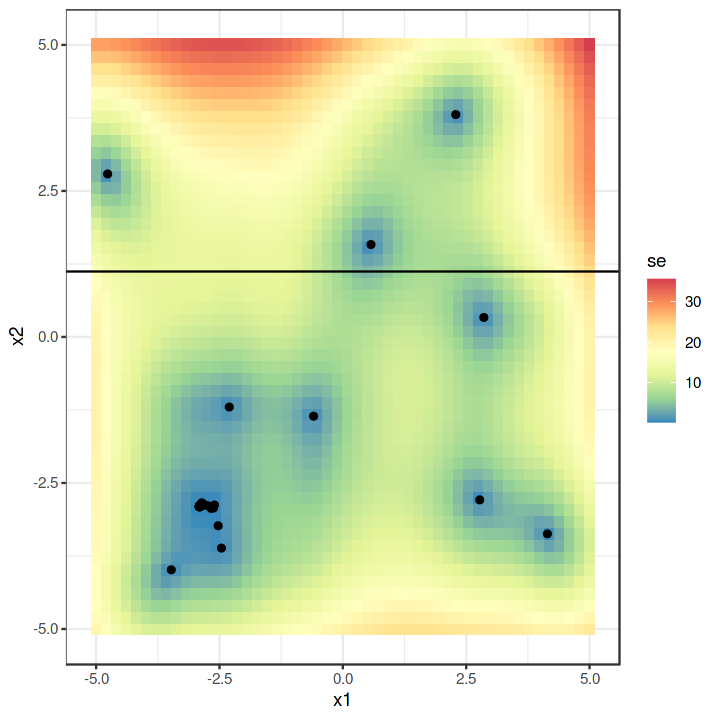

In [337]:
options(repr.plot.width = 6, repr.plot.height = 6)

p1 = ggplot(data = preds[type == model_for_interpretation, ], aes(x = x1, y = x2, fill = se)) + geom_tile() + geom_point(data = opdf[type == model_for_interpretation, ], aes(x = x1, y = x2)) 
p1 = p1 + geom_hline(yintercept = split$split.points[[1]]) + scale_fill_distiller(palette = "Spectral")
p1

In [339]:
eff_new = merge(eff, df[, c(".id", "x2")], by = ".id")

In [340]:
eff_new$node = (eff_new$x2 < split$split.points[[1]]) * 1

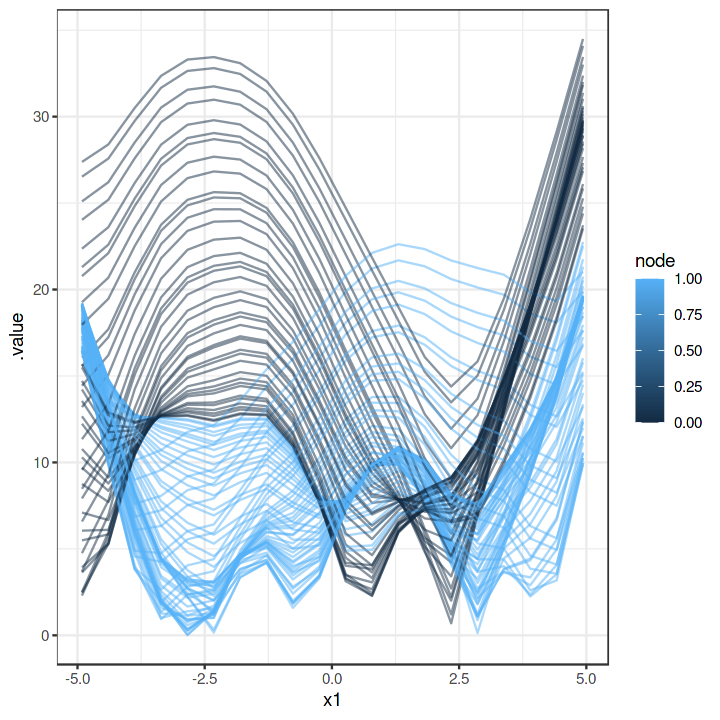

In [341]:
p = ggplot(data = eff_new, aes(x = x1, y = .value, colour = node, group = .id)) + geom_line(alpha = 0.5)
p

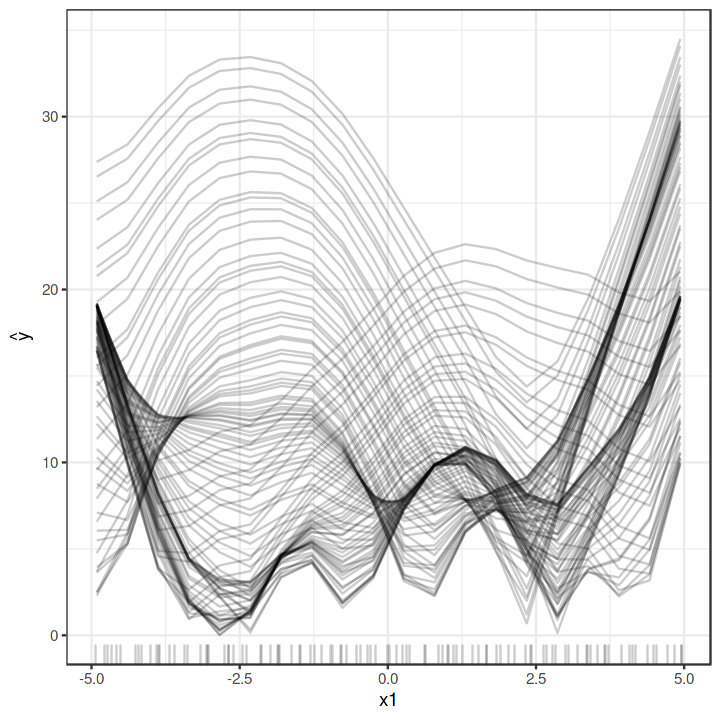

In [342]:
effect$plot()

In [343]:
# eff = eff[, .value := (.value - mean(.value)), by = c(".type", ".id")]
Y = tidyr::spread(eff_new[node == 1, c("x1", ".value", ".type", ".id")], x1, .value)
Y = as.data.frame(Y)
Y = Y[, setdiff(colnames(Y), c(".type", ".id"))]
X = df
X = X[X$x2 < split$split.points[[1]], ]
X = X[, c("x2"), drop = FALSE]

In [344]:
split = split_parent_node(Y = Y, X = X, objective = SS_L1, optimizer = find_best_binary_split)
split

feature,objective.value,runtime,split.points,best.split
<chr>,<dbl>,<dbl>,<list>,<lgl>
x2,2454.87,0.009,-3.90275,TRUE


In [346]:
newnodes = ifelse(eff_new[eff_new$node == 1, ]$x2 < split$split.points[[1]], 1, 2)

In [348]:
eff_new[eff_new$node == 1, "node"] = newnodes

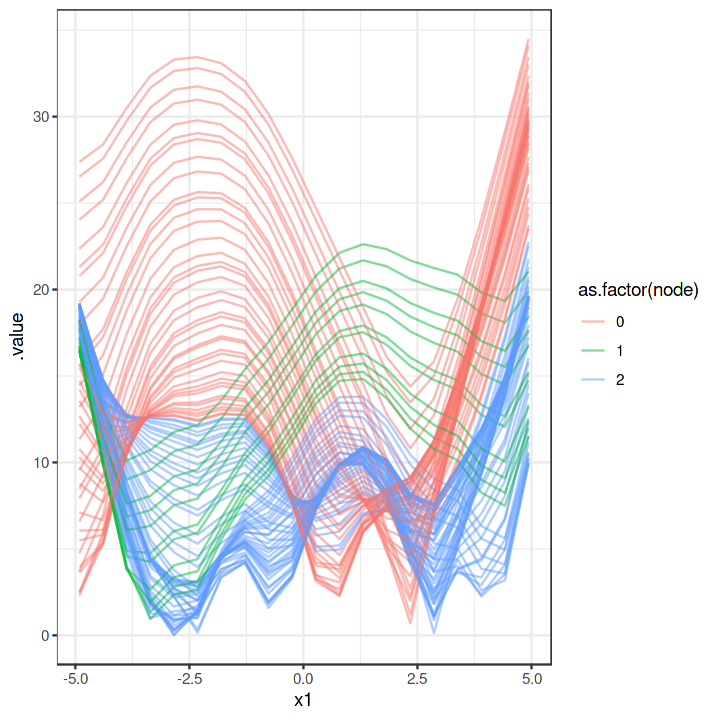

In [351]:
p = ggplot(data = eff_new, aes(x = x1, y = .value, colour = as.factor(node), group = .id)) + geom_line(alpha = 0.5)
p